In [1]:
!pip install cython
!pip install sparsearray
!pip install evodag
!pip install EvoMSA
!pip install nltk

In [2]:
from EvoMSA import base
import pandas as pd
import nltk
import numpy as np
import os
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/bob/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Load Data

In [45]:
STS_RAW_TRAIN_PATH = 'data/sts/training.1600000.processed.noemoticon.csv'
STS_RAW_TEST_PATH  = 'data/sts/testdata.manual.2009.06.14.csv'

STS_PROCESED_TRAIN_PATH = 'data/processed/sts/sts_train/part-00000-cb0067aa-b4b0-432b-b2a1-76cd252321ab-c000.csv'
STS_PROCESED_TEST_PATH  = 'data/processed/sts/sts_test/part-00000-5bbb61a5-5ed0-4537-a2bf-e42828225936-c000.csv'

COVID_PROCESSED_PATH = 'data/processed/full-tweets-sanitized/tweets-santized/Tweets_fully_processed.csv'

In [4]:
df_sts_train = pd.read_csv(STS_RAW_TRAIN_PATH, 
                           sep=',', 
                           header=None,
                           usecols=[0,1,5],
                           names=['label','id','text'],
                           dtype={'id':np.int64, 'text':"string",'label':"string"},
                           encoding = "ISO-8859-1", 
                           engine='python')


In [5]:
df_sts_train.head(5)

,label,id,text
0,0,1467810369,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,is upset that he can't update his Facebook by ...
2,0,1467810917,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,my whole body feels itchy and like its on fire
4,0,1467811193,"@nationwideclass no, it's not behaving at all...."


In [6]:
df_sts_train.dtypes

label    string
id        int64
text     string
dtype: object

# Train evoMSA model
Train the evoMSA model

In [7]:
from sklearn import model_selection

In [8]:
train = df_sts_train.sample(40000)

In [9]:
from sklearn.svm import LinearSVC
class MySVM(LinearSVC):
  def __init__(self, max_iter=50000, **kwargs):
    super(MySVM, self).__init__(max_iter=max_iter, **kwargs)

In [10]:
from EvoMSA.utils import download

In [11]:
models = [["b4msa.textmodel.TextModel", MySVM],
          [download("emo_En.tm"), MySVM],
          ["EvoMSA.model.ThumbsUpDownEn", MySVM]]

In [12]:
evo = base.EvoMSA(TR=False, models=models, classifier=True, lang='en', n_jobs=0,tm_n_jobs=0)

In [13]:
del df_sts_train

In [14]:
evo.fit(train.text, train.label)

2020-11-10 10:42:30,432 : INFO : sws for  english
2020-11-10 10:42:30,439 : INFO : loading emotions from file... /opt/conda/lib/python3.7/site-packages/ConceptModelling/data/en.affective.words.json 
100%|██████████| 30/30 [42:17<00:00, 84.59s/it]  


# Performance

In [26]:
df_sts_test = pd.read_csv(STS_RAW_TEST_PATH, 
                           sep=',',
                           header=None,
                           usecols=[0,1,5],
                           names=['label','id','text'],
                           dtype={'id':np.int64, 'text':"string",'label':"string"},
                           encoding = "ISO-8859-1", 
                           engine='python')

In [27]:
evo.predict(['sad'])

100%|██████████| 30/30 [00:02<00:00, 14.32it/s]


array([0])

In [32]:
evo.predict(['happy'])

100%|██████████| 30/30 [00:01<00:00, 15.88it/s]


array([4])

In [28]:
from sklearn import metrics

In [29]:
df_sts_test = df_sts_test[df_sts_test.label!='2']
df_sts_test

,label,id,text
0,4,3,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Reading my kindle2... Love it... Lee childs i...
2,4,5,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,@kenburbary You'll love your Kindle2. I've had...
4,4,7,@mikefish Fair enough. But i have the Kindle2...
...,...,...,...
492,4,14071,"After using LaTeX a lot, any other typeset mat..."
494,0,14073,"On that note, I hate Word. I hate Pages. I hat..."
495,4,14074,Ahhh... back in a *real* text editing environm...
496,0,14075,"Trouble in Iran, I see. Hmm. Iran. Iran so far..."


In [30]:
pred = evo.predict(df_sts_test.text)

100%|██████████| 30/30 [00:02<00:00, 12.95it/s]


In [33]:
metrics.f1_score(df_sts_test.label.astype(int), pred, average='macro' )

0.8103362545838773

Confusion matrix:
 [[139  38]
 [ 30 152]]


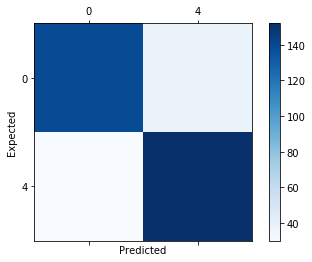

In [34]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(df_sts_test.label.astype(int), y_pred=pred)
print('Confusion matrix:\n', conf_mat)

labels = ['0','4']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

# Labeling COVID Dataset

In [57]:
COVID_LABELED_PATH = 'data/processed/full-tweets-sanitized/tweets-santized/COVID_processed_labeled.csv'

In [47]:
covid_data = pd.read_csv(COVID_PROCESSED_PATH, 
                           sep=',', 
                           header=None,
                           names=['id','text'],
                           dtype={'id':'string', 'text':"string"},
                           encoding = "ISO-8859-1", 
                           engine='python')


In [49]:
covid_data.dropna(inplace=True)

In [50]:
covid_pred = evo.predict(covid_data.text)


100%|██████████| 3/3 [06:43<00:00, 134.62s/it]

100%|██████████| 3/3 [00:06<00:00,  2.11s/it]

100%|██████████| 30/30 [03:12<00:00,  6.41s/it]


In [51]:
covid_data['label'] = covid_pred

In [58]:
covid_data.to_csv(COVID_LABELED_PATH, index = False, header=True)